# Autonomous Ship Transition Simulator

# Introduction
This is an autonomous ship transition simulator for the regulators, users and manufactures etc. of the autonomous ship and its components. By utilizing this simulator, regulators can consider development support for specific technologies and the introduction of new rules to tackle the problems regarding maritime safety and labor environment improvement. In addition, their users and developers can consider what kind of ship can be competitive in the future and invest in specific technology and infrastructure.

---
# はじめに
自動運航船が将来どのように導入されうるかを推測するシミュレータです．想定ユーザは自動運航船・および構成システムの製造者（造船所・舶用機器メーカ），ユーザ（船会社），レギュレータ（IMO，国，船級など）及びそれを模擬したい人です．このシミュレータによって，例えば以下を検討することが可能です．
* どの技術やインフラにどの程度投資すべきか．どのようなルールが必要か．
* どのような自動運航船や技術が将来競争力を持つか．

# 1. Preparation
---
* Mount to use files on Google Drive.
---
* まずはGoogle Drive上のファイルを参照できるようにマウントします．
---

In [ ]:
# For google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Set Home Directory
---
* Please change 'homedir' according to your simulation environment.
---
* homedirをご自身の場所に合わせて変更ください．
---

In [ ]:
homedir = "/content/drive/MyDrive/MIT_shared/2021-2022/03_自動運航船プロジェクト/autoship_trans_sim/"

In [ ]:
# Import modules
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import itertools

# 3. Import functions for getting scenario, cost and specification data
----
There are mainly two options prepared for reading input files.
1. Using yaml file by just setting initial numbers and growth rates for each timeline. 
* scenario
* cost
* spec
2. Using csv files can set the timeline of each cost and demand in detail, not only setting just initial numbers and growth rates. Please note that you have to set additional global parameters.
* demand
* cost
* spec

```python
# Import from csv files (Optional)
cost = pd.read_csv("csv/cost.csv")
spec = pd.read_csv("csv/spec.csv")
demand = pd.read_csv("csv/demand.csv")
```
----
インプットファイルの読み込みには2通りあります．
1. yamlファイルを用いてInputファイルを作成するパターン．初期値と変化率で設定．
* scenario: 船の需要や平均船齢など
* cost: 様々なコストなど
* spec: 様々な船タイプのスペック（主に，AsIsと比較した際の変化率で設定）

2. Ircsvファイルを用いてInputファイルを用意しておくパターン．一定の変化率でなく，時系列変化を詳細に記述可能．
* demand: 船の需要
* cost: 様々なコストなど
* spec: 様々な船タイプのスペック（主に，AsIsと比較した際の変化率で設定）
※いくつかグローバル変数設定必要

In [ ]:
# Set scenario by yaml
def get_scenario(scenario='scenario_1'):
    check = True
    # folder_pass = 'yml/scenario/'
    folder_pass = homedir + 'yml/scenario/' # Google Colab用に変更
    while check:
        try:
            with open(folder_pass + scenario + ".yml") as yml:
                scenario = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            scenario = input("Set scenario %s (yml filename wo/extention)")

    column = ['Year', 'NumofShip', 'Newbuilding', 'Scrap']
    
    ship_initial = scenario['ship_demand']['initial_number']
    annual_growth = scenario['ship_demand']['annual_growth']
    ship_age = scenario['ship_age']
    start_year = scenario['sim_setting']['start_year']
    end_year = scenario['sim_setting']['end_year']

    Year = list(range(start_year, end_year+1))
    sim_years = len(Year)
    
    NumofShip = [0] * sim_years
    Newbuilding = [0] * sim_years
    Scrap = [0] * sim_years    
    for i in range (sim_years):
        NumofShip[i] = int(NumofShip[i-1] * annual_growth) if i>0 else ship_initial
        Scrap[i]= int(ship_initial/ship_age) if i <= ship_age else Newbuilding[i-ship_age]
        Newbuilding[i] = NumofShip[i] + Scrap[i] - NumofShip[i-1] if i>0 else int(ship_initial/ship_age)

    df_demand = pd.DataFrame(zip(Year, NumofShip, Newbuilding, Scrap), columns = column)
    return df_demand, ship_age

In [ ]:
# Set cost time series by yaml
def get_cost(Year, cost='cost_1'):
    check = True
    # folder_pass = 'yml/cost/' 
    folder_pass = homedir + 'yml/cost/' # Google Colab用に変更
    while check:
        try:
            with open(folder_pass + cost + ".yml") as yml:
                cost = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            cost = input("Set cost %s (yml filename wo/extention)")
    
    column = ['Year','Seafarer','ShoreOperator','ExpLoss','CS','Comm','Situ','Plan','Exec','RemOpe','RemMon','Fuel']
    
    sf_cost_initial = cost['seafarer_cost']['initial_number']
    sf_cost_growth = cost['seafarer_cost']['annual_growth']
    so_cost_initial = cost['shore_operator_cost']['initial_number']
    so_cost_growth = cost['shore_operator_cost']['annual_growth']
    loss_initial = cost['exp_loss']['initial_number']
    loss_growth = cost['exp_loss']['annual_growth']
    cs_initial = cost['opex_cyber_security']['initial_number']
    cs_growth = cost['opex_cyber_security']['annual_growth']
    com_initial = cost['opex_communication']['initial_number']
    com_growth = cost['opex_communication']['annual_growth']
    sa_initial = cost['capex_situation_awareness']['initial_number']
    sa_growth = cost['capex_situation_awareness']['annual_growth']
    pl_initial = cost['capex_planning']['initial_number']
    pl_growth = cost['capex_planning']['annual_growth']
    ex_initial = cost['capex_execution']['initial_number']
    ex_growth = cost['capex_execution']['annual_growth']
    ro_initial = cost['capex_remote_operation']['initial_number']
    ro_growth = cost['capex_remote_operation']['annual_growth']
    rm_initial = cost['capex_remote_monitoring']['initial_number']
    rm_growth = cost['capex_remote_monitoring']['annual_growth']
    fc_initial = cost['fuel_cost']['initial_number']
    fc_growth = cost['fuel_cost']['annual_growth']

    sim_years = len(Year)
    Seafarer = [0] * sim_years
    ShoreOperator = [0] * sim_years
    ExpLoss = [0] * sim_years  
    CS = [0] * sim_years
    Comm = [0] * sim_years
    Situ = [0] * sim_years
    Plan = [0] * sim_years
    Exec = [0] * sim_years
    RemOpe = [0] * sim_years
    RemMon = [0] * sim_years   
    Fuel = [0] * sim_years   

    for i in range (sim_years):
        Seafarer[i] = int(Seafarer[i-1] * sf_cost_growth) if i>0 else sf_cost_initial
        ShoreOperator[i] = int(ShoreOperator[i-1] * so_cost_growth) if i>0 else so_cost_initial
        ExpLoss[i] = int(ExpLoss[i-1] * loss_growth) if i>0 else loss_initial
        CS[i] = int(CS[i-1] * cs_growth) if i>0 else cs_initial
        Comm[i] = int(Comm[i-1] * com_growth) if i>0 else com_initial
        Situ[i] = int(Situ[i-1] * sa_growth) if i>0 else sa_initial
        Plan[i] = int(Plan[i-1] * pl_growth) if i>0 else pl_initial
        Exec[i] = int(Exec[i-1] * ex_growth) if i>0 else ex_initial
        RemOpe[i] = int(RemOpe[i-1] * ro_growth) if i>0 else ro_initial
        RemMon[i] = int(RemMon[i-1] * rm_growth) if i>0 else rm_initial
        Fuel[i] = int(Fuel[i-1] * fc_growth) if i>0 else fc_initial
    
    df_cost = pd.DataFrame(zip(Year, Seafarer, ShoreOperator, ExpLoss, CS, Comm, Situ, Plan, Exec, RemOpe, RemMon,Fuel), columns = column)
    return df_cost

In [ ]:
# Set spec of each ship by yaml
def get_spec(spec='spec_1'):
    check = True
    # folder_pass = 'yml/spec/' 
    folder_pass = homedir + 'yml/spec/' # Google Colab用に変更
    while check:
        try:
            with open(folder_pass + spec + ".yml") as yml:
                spec = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            spec = input("Set spec %s (yml filename wo/extention)" % str(id)) # set each ship spec

    options = len(spec['SituationAwareness']) * len(spec['Control']) * len(spec['Control']) * len(spec['Remote'])
    column = ['ship_type', 'Control', 'Planning', 'SituationAwareness', 'Remote', 'sec_cost', 'com_cost', 'acc_ratio', 'sa_cost', 'pl_cost', 'ex_cost', 'ro_cost', 'rm_cost', 'num_sf', 'num_so', 'foc']
    
    ship_type = [''] * options
    Control = [''] * options
    Planning = [''] * options
    SituationAwareness = [''] * options
    Remote = [''] * options
    sec_cost = [0] * options
    com_cost = [0] * options
    acc_ratio = [0] * options
    sa_cost = [0] * options
    pl_cost = [0] * options
    ex_cost = [0] * options
    ro_cost = [0] * options
    rm_cost = [0] * options
    num_sf = [0] * options
    num_so = [0] * options
    foc = [0] * options

    CPSR = list(itertools.product(spec['Control'], spec['Planning'], spec['SituationAwareness'],spec['Remote']))
    Control, Planning, SituationAwareness, Remote = [r[0] for r in CPSR], [r[1] for r in CPSR], [r[2] for r in CPSR], [r[3] for r in CPSR]
    
    for i in range(options):
        ship_type[i] = 'ship_' + str(i+1) 
        sec_cost[i] = spec['Control'][Control[i]]['sec_cost']+spec['Planning'][Planning[i]]['sec_cost']+spec['SituationAwareness'][SituationAwareness[i]]['sec_cost']+spec['Remote'][Remote[i]]['sec_cost']-4
        com_cost[i] = spec['Control'][Control[i]]['com_cost']+spec['Planning'][Planning[i]]['com_cost']+spec['SituationAwareness'][SituationAwareness[i]]['com_cost']+spec['Remote'][Remote[i]]['com_cost']-4
        acc_ratio[i] = spec['Control'][Control[i]]['acc_ratio']*spec['Planning'][Planning[i]]['acc_ratio']*spec['SituationAwareness'][SituationAwareness[i]]['acc_ratio']
        sa_cost[i] = spec['SituationAwareness'][SituationAwareness[i]]['sa_cost']
        pl_cost[i] = spec['Planning'][Planning[i]]['pl_cost']
        ex_cost[i] = spec['Control'][Control[i]]['ex_cost']
        ro_cost[i] = spec['Remote'][Remote[i]]['ro_cost']
        rm_cost[i] = spec['Remote'][Remote[i]]['rm_cost']
        num_sf_tmp = spec['Control'][Control[i]]['num_sf']+spec['Planning'][Planning[i]]['num_sf']+spec['SituationAwareness'][SituationAwareness[i]]['num_sf']
        num_so[i] = int(num_sf_tmp*spec['Remote'][Remote[i]]['num_so_ratio'])
        num_sf[i] = num_sf_tmp - num_so[i]
        foc[i] = (1 - (8 - num_sf[i])/200) if num_sf[i] >0 else 0.9 # Assume max seafarer = 8
    
    spec = pd.DataFrame(zip(ship_type, Control, Planning, SituationAwareness, Remote, sec_cost, com_cost, acc_ratio, sa_cost, pl_cost, ex_cost, ro_cost, rm_cost, num_sf, num_so, foc), columns = column)
    return spec

# 4. Policy of Ship Selection ⚓
船社のつもりになって，船舶の選定時にどのようなファクターに重きを置くか考えてみましょう．

|パラメータ|イメージ|重み|
|---|---|---|
|economy|判断時の価値ベースでの損益見積|0-1|
|environment|CO2排出量（→総燃料消費額）|0-1|
|safety|事故発生率（→事故損害見積額）|0-1|
|labour|労働者の確保（→総人件費）|0-1|

In [ ]:
def select_ship(spec, cost, year, ship_age):
    # Set yaml file
    #@title What will you prioritize for selecting ships?　{ run: "auto" }

    economy = 1 #@param {type:"slider", min:0, max:1, step:0.1}
    environment = 0 #@param {type:"slider", min:0, max:1, step:0.1}
    safety = 0 #@param {type:"slider", min:0, max:1, step:0.1}
    labour = 0 #@param {type:"slider", min:0, max:1, step:0.1}

    labour_cost = spec.num_sf * cost.Seafarer[year] \
                + spec.num_so * cost.ShoreOperator[year]
    fuel_cost   = spec.foc * cost.Fuel[year]
    com_sec_cost= spec.sec_cost * cost.CS[year] \
                + spec.com_cost * cost.Comm[year]
    opex_sum    = labour_cost + fuel_cost + com_sec_cost
    capex_sum   = spec.sa_cost * cost.Situ[year] \
                + spec.pl_cost * cost.Plan[year] \
                + spec.ex_cost * cost.Exec[year] \
                + spec.ro_cost * cost.RemOpe[year] \
                + spec.rm_cost * cost.RemMon[year]
    ac_loss     = spec.acc_ratio * cost.ExpLoss[year]
    annual_cost = opex_sum + capex_sum/ship_age + ac_loss
    sf_sum      = spec.num_sf + spec.num_so

    select_parameter = annual_cost * economy \
                     + fuel_cost * environment \
                     + ac_loss * safety \
                     + labour_cost * labour #要正規化 
    select      = select_parameter.idxmin()   
    # seafarerの増減率をながらかにするようなファクター → TBD

    return select, annual_cost, opex_sum, capex_sum, ac_loss, sf_sum, fuel_cost

# Set the casename

In [ ]:
casename = 'test_0330'

# 5. Technology Investment ⚓
メーカや国のつもりになって，どのような技術開発をより支援したいか，考えてみましょう．

|パラメータ|イメージ|重み|
|---|---|---|
|sa_growth|認知・判断モジュールへの投資（→価格の低下率/年）|0-1|
|pl_growth|計画策定モジュールへの投資（→価格の低下率/年）|0-1|
|ex_growth|制御・行動モジュールへの投資（→価格の低下率/年）|0-1|
|ro_growth|遠隔支援モジュールへの投資（→価格の低下率/年）|0-1|
|fuel_growth|燃料費上昇シナリオ（燃料，CO2の上昇率/年）|1-|

In [ ]:
# Set yaml file
#@title What is your choice for technology investment and fuel price incl. CO2?　{ run: "auto" }

# 投資額等，より実際の意思決定に近い項目で設定したい．（もしくは「大中小」等でぼかす）
sa_growth = '0.99' #@param ['0.9','0.95','0.99']
pl_growth = '0.99' #@param ['0.9','0.95','0.99']
ex_growth = '0.9' #@param ['0.9','0.95','0.99']
ro_growth = '0.99' #@param ['0.9','0.95','0.99']
fuel_growth = '1.01' #@param ['1.01','1.05','1.1']

# with open("yml/cost/cost_tmp.yml", "w") as yf:
# if not os.path.exists(new_dir_path):
#     os.makedirs(new_dir_path)
with open(homedir + "yml/cost/cost_"+casename+".yml", "w") as yf: # Google Colab用に変更
    yaml.dump({
        "seafarer_cost": {
            "initial_number": 200000, 
            "annual_growth": 1.01
        },
        "shore_operator_cost": {
            "initial_number": 100000,
            "annual_growth": 1.01
        },
        "exp_loss": {
            "initial_number": 3000000, 
            "annual_growth": 1.01
        },
        "opex_cyber_security": {
            "initial_number": 12000,
            "annual_growth": 1.01
        },
        "opex_communication": {
            "initial_number": 45000,
            "annual_growth": 0.95
        },
        "capex_situation_awareness": {
            "initial_number": 4000000,
            "annual_growth": float(sa_growth)
        },
        "capex_planning": {
            "initial_number": 6000000,
            "annual_growth": float(pl_growth)
        },
        "capex_execution": {
            "initial_number": 8000000,
            "annual_growth": float(ex_growth)
        },
        "capex_remote_operation": {
            "initial_number": 4000000,
            "annual_growth": float(ro_growth)
        },
        "capex_remote_monitoring": {
            "initial_number": 1000000,
            "annual_growth": float(ro_growth)
        },
        "fuel_cost": {
            "initial_number": 1420000, # incl. CO2 cost
            "annual_growth": float(fuel_growth)
        }
    }, yf, default_flow_style=False)

In [ ]:
with open(homedir + "yml/scenario/scenario_"+casename+".yml", "w") as yf: # Google Colab用に変更
    yaml.dump({
        "sim_setting": {
            "start_year": 2022, 
            "end_year": 2070
        },
        "ship_demand": {
            "initial_number": 5200,
            "annual_growth": 1.01
        },
        "ship_age": 20
    }, yf, default_flow_style=False)

In [ ]:
with open(homedir + "yml/spec/spec_"+casename+".yml", "w") as yf: # Google Colab用に変更
    yaml.dump({
        "SituationAwareness": {
            "FullAuto": {
                "num_sf": 0,
                "sec_cost": 10,
                "com_cost": 10,
                "acc_ratio": 0.5,
                "sa_cost": 1
            },
            "SemiAuto": {
                "num_sf": 1,
                "sec_cost": 3,
                "com_cost": 3,
                "acc_ratio": 0.75,
                "sa_cost": 0.5
            },
            "AsIs": {
                "num_sf": 2,
                "sec_cost": 1,
                "com_cost": 1,
                "acc_ratio": 1,
                "sa_cost": 0
            }
        },
        "Planning": {
            "FullAuto": {
                "num_sf": 0,
                "sec_cost": 10,
                "com_cost": 10,
                "acc_ratio": 0.4,
                "pl_cost": 1
            },
            "SemiAuto": {
                "num_sf": 2,
                "sec_cost": 3,
                "com_cost": 3,
                "acc_ratio": 0.6,
                "pl_cost": 0.5
            },
            "AsIs": {
                "num_sf": 4,
                "sec_cost": 1,
                "com_cost": 1,
                "acc_ratio": 1,
                "pl_cost": 0
            }
        },
        "Control": {
            "FullAuto": {
                "num_sf": 0,
                "sec_cost": 10,
                "com_cost": 10,
                "acc_ratio": 0.5,
                "ex_cost": 1
            },
            "SemiAuto": {
                "num_sf": 1,
                "sec_cost": 3,
                "com_cost": 3,
                "acc_ratio": 0.75,
                "ex_cost": 0.5
            },
            "AsIs": {
                "num_sf": 2,
                "sec_cost": 1,
                "com_cost": 1,
                "acc_ratio": 1,
                "ex_cost": 0
            }
        },
        "Remote": {
            "Control": {
                "num_so_ratio": 1,
                "sec_cost": 10,
                "com_cost": 10,
                "ro_cost": 1,
                "rm_cost": 0
            },
            "Monitor": {
                "num_so_ratio": 0.5,
                "sec_cost": 3,
                "com_cost": 3,
                "ro_cost": 0,
                "rm_cost": 1
            },
            "NaN": {
                "num_so_ratio": 0,
                "sec_cost": 1,
                "com_cost": 1,
                "ro_cost": 0,
                "rm_cost": 0
            }
        }
    }, yf, default_flow_style=False)

# 6. Import YAML files and check the input data

In [ ]:
# Import from yaml files
demand, ship_age = get_scenario('scenario_'+casename)
cost = get_cost(demand.Year, 'cost_'+casename)
spec = get_spec('spec_'+casename)

In [ ]:
demand

,Year,NumofShip,Newbuilding,Scrap
0,2022,5200,260,260
1,2023,5252,312,260
2,2024,5304,312,260
3,2025,5357,313,260
4,2026,5410,313,260
5,2027,5464,314,260
6,2028,5518,314,260
7,2029,5573,315,260
8,2030,5628,315,260
9,2031,5684,316,260


In [ ]:
cost

,Year,Seafarer,ShoreOperator,ExpLoss,CS,Comm,Situ,Plan,Exec,RemOpe,RemMon,Fuel
0,2022,200000,100000,3000000,12000,45000,4000000,6000000,8000000,4000000,1000000,1420000
1,2023,202000,101000,3030000,12120,42750,3960000,5940000,7200000,3960000,990000,1434200
2,2024,204020,102010,3060300,12241,40612,3920400,5880600,6480000,3920400,980100,1448542
3,2025,206060,103030,3090903,12363,38581,3881196,5821794,5832000,3881196,970299,1463027
4,2026,208120,104060,3121812,12486,36651,3842384,5763576,5248800,3842384,960596,1477657
5,2027,210201,105100,3153030,12610,34818,3803960,5705940,4723920,3803960,950990,1492433
6,2028,212303,106151,3184560,12736,33077,3765920,5648880,4251528,3765920,941480,1507357
7,2029,214426,107212,3216405,12863,31423,3728260,5592391,3826375,3728260,932065,1522430
8,2030,216570,108284,3248569,12991,29851,3690977,5536467,3443737,3690977,922744,1537654
9,2031,218735,109366,3281054,13120,28358,3654067,5481102,3099363,3654067,913516,1553030


In [ ]:
spec

,ship_type,Control,Planning,SituationAwareness,Remote,sec_cost,com_cost,acc_ratio,sa_cost,pl_cost,ex_cost,ro_cost,rm_cost,num_sf,num_so,foc
0,ship_1,AsIs,AsIs,AsIs,Control,9,9,1.0000,0.0,0.0,0.0,1,0,0,8,0.900
1,ship_2,AsIs,AsIs,AsIs,Monitor,2,2,1.0000,0.0,0.0,0.0,0,1,4,4,0.980
2,ship_3,AsIs,AsIs,AsIs,NaN,0,0,1.0000,0.0,0.0,0.0,0,0,8,0,1.000
3,ship_4,AsIs,AsIs,FullAuto,Control,18,18,0.5000,1.0,0.0,0.0,1,0,0,6,0.900
4,ship_5,AsIs,AsIs,FullAuto,Monitor,11,11,0.5000,1.0,0.0,0.0,0,1,3,3,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,ship_77,SemiAuto,SemiAuto,FullAuto,Monitor,15,15,0.2250,1.0,0.5,0.5,0,1,2,1,0.970
77,ship_78,SemiAuto,SemiAuto,FullAuto,NaN,13,13,0.2250,1.0,0.5,0.5,0,0,3,0,0.975
78,ship_79,SemiAuto,SemiAuto,SemiAuto,Control,15,15,0.3375,0.5,0.5,0.5,1,0,0,4,0.900
79,ship_80,SemiAuto,SemiAuto,SemiAuto,Monitor,8,8,0.3375,0.5,0.5,0.5,0,1,2,2,0.970


# 7. Trade Space Analysis ⚓
オプションを比較しながら，どのタイプが最も競争力があるか見てみましょう．

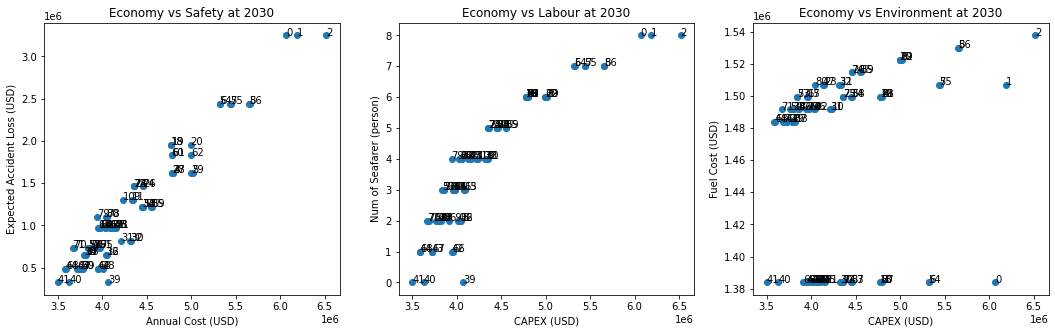

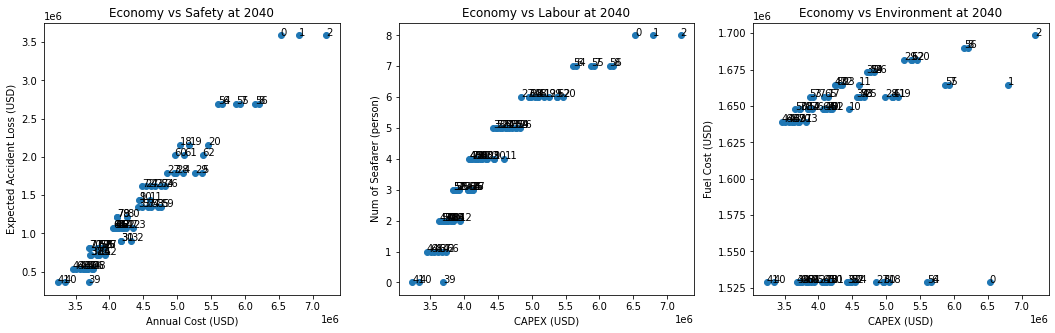

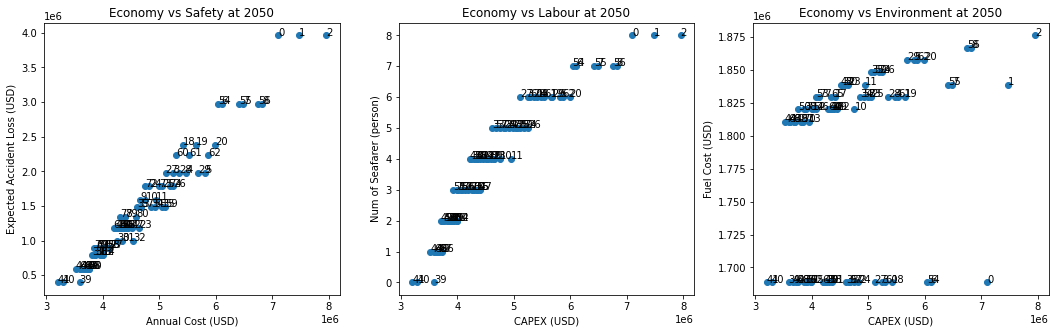

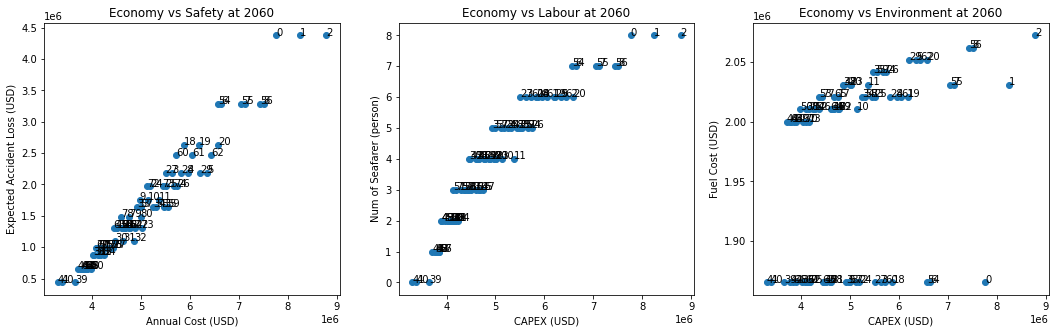

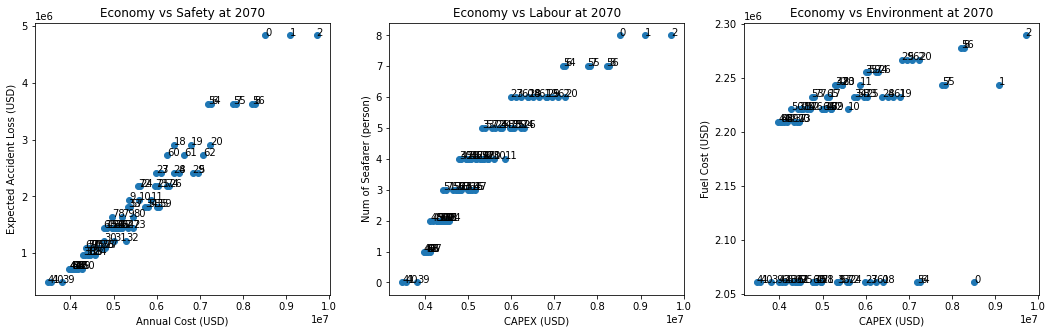

In [ ]:
# Select Ship and show Tradespace
select = [0] * len(cost.Year)
labels = []

for i in range(len(cost.Year)):
    select[i], annual_cost, opex_sum, capex_sum, ac_loss, sf_sum, fuel_cost = select_ship(spec, cost, i, ship_age)
    
    # Show tradespace
    if cost.Year[i]%10==0:
        fig = plt.figure(figsize=(18,5))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        ax1.scatter(x=annual_cost, y=ac_loss)
        ax1.set_title("Economy vs Safety at " + str(cost.Year[i]))
        ax1.set_xlabel("Annual Cost (USD)")
        ax1.set_ylabel("Expected Accident Loss (USD)")
        ax2.scatter(x=annual_cost, y=sf_sum)
        ax2.set_title("Economy vs Labour at " + str(cost.Year[i]))
        ax2.set_xlabel("CAPEX (USD)")
        ax2.set_ylabel("Num of Seafarer (person)")
        ax3.scatter(x=annual_cost, y=fuel_cost)
        ax3.set_title("Economy vs Environment at " + str(cost.Year[i]))
        ax3.set_xlabel("CAPEX (USD)")
        ax3.set_ylabel("Fuel Cost (USD)")
        for j, label in enumerate(spec.index.values):
            ax1.text(annual_cost[j], ac_loss[j], label)
            ax2.text(annual_cost[j], sf_sum[j], label)
            ax3.text(annual_cost[j], fuel_cost[j], label)
        plt.show()

# 8. Calculate the number of annual newbuildings and scraps

In [ ]:
# Initiate result dataframe
result = pd.DataFrame(demand.Year)
for s in list(set(spec.ship_type[select])):
    result[s] = 0
# Add conventional ship
conv_ship = len(spec)-1
result[spec.ship_type[conv_ship]] = 0

# Calculate number of ships
result[spec.ship_type[conv_ship]][0] = demand.NumofShip[0] # Initial num of ship
for i in range(len(cost.Year)):
    for s in list(set(spec.ship_type[select])):
        result.at[i,s] = result.at[i-1,s] if i >= 1 else 0
    result[spec.ship_type[select[i]]][i] += demand.Newbuilding[i]
    if i-ship_age > 0:
        result[spec.ship_type[select[i-ship_age-1]]][i] -= demand.Newbuilding[i-ship_age-1]
    if i >= 1 and i <= ship_age:
        result[spec.ship_type[conv_ship]][i] = result[spec.ship_type[conv_ship]][i-1] - demand.Scrap[i]

# 9. Import function for result calculation

In [ ]:
def result_calc(s, spec, cost, year, num, ship_age):
    i = spec.index[spec.ship_type == s].tolist()[0]
    LabourCost = (spec.num_sf[i] * cost.Seafarer[year] + spec.num_so[i] * cost.ShoreOperator[year]) * num
    OpeCost = (spec.sec_cost[i] * cost.CS[year] + spec.com_cost[i] * cost.Comm[year]) * num
    FuelCost = spec.foc[i] * cost.Fuel[year] * num
    OnboardAsset = (spec.sa_cost[i] * cost.Situ[year] + spec.pl_cost[i] * cost.Plan[year] + spec.ex_cost[i] * cost.Exec[year])/ship_age * num
    ShoreAsset = (spec.ro_cost[i] * cost.RemOpe[year] + spec.rm_cost[i] * cost.RemMon[year])/ship_age * num 
    LossDamage = (spec.acc_ratio[i] * cost.ExpLoss[year]) * num
    Seafarer = spec.num_sf[i] * num
    ShoreOperator = spec.num_so[i] * num
    
    return LabourCost, OpeCost, FuelCost, OnboardAsset, ShoreAsset, LossDamage, Seafarer, ShoreOperator

# 10. Calculate Results

In [ ]:
labels1 = list(set(spec.ship_type[select]))
labels1.append(spec.ship_type[conv_ship])
labels1 = sorted(labels1, reverse=True)

# Calculate Other Parameters
result['LabourCost'] = 0
result['OpeCost'] = 0
result['FuelCost'] = 0
result['OnboardAsset'] = 0
result['ShoreAsset'] = 0
result['LossDamage'] = 0
result['Seafarer'] = 0
result['ShoreOperator'] = 0
result['LossDamagePerVessel'] = 0
for i in range(len(cost.Year)):
    a = [0] * 8
    for s in labels1:
        new = list(result_calc(s, spec, cost, i, result.at[i,s], ship_age))
        a = [x + y for (x, y) in zip(a, new)]
    
    result.LabourCost[i], result.OpeCost[i], result.FuelCost[i], result.OnboardAsset[i], result.ShoreAsset[i], result.LossDamage[i], result.Seafarer[i], result.ShoreOperator[i] = a

result.LossDamagePerVessel = [a/b for (a,b) in zip(result.LossDamage, demand.NumofShip)]

# 11. Get Possible roadmap for Autonomous Ship Transition ⚓
ロードマップを確認し，どのような自動運航船がいつ頃投入されるか確認してみましょう．

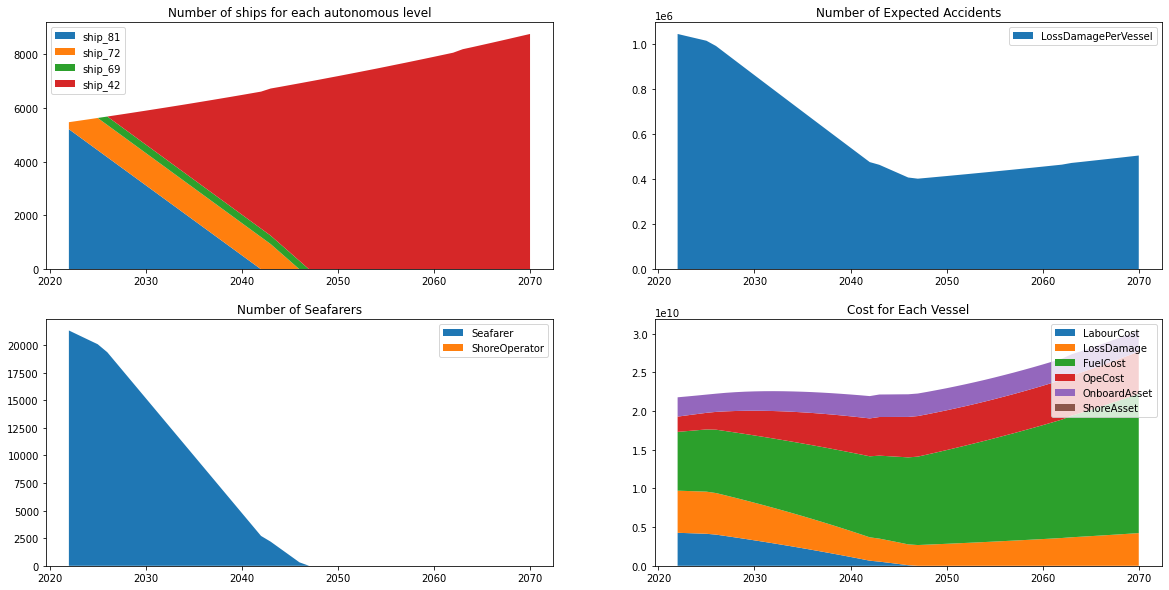

ship_81 | SituationAwareness: SemiAuto | Planning: SemiAuto | Control: SemiAuto | Remote: NaN
ship_72 | SituationAwareness: SemiAuto | Planning: FullAuto | Control: SemiAuto | Remote: NaN
ship_69 | SituationAwareness: FullAuto | Planning: FullAuto | Control: SemiAuto | Remote: NaN
ship_42 | SituationAwareness: FullAuto | Planning: FullAuto | Control: FullAuto | Remote: NaN


In [ ]:
# Show Outputs
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.stackplot(result.Year, [result[s] for s in labels1], labels=labels1)
ax1.set_title("Number of ships for each autonomous level")
ax1.legend(loc="upper left")

labels2 = ['LossDamagePerVessel']
ax2.stackplot(result.Year, result.LossDamagePerVessel, labels=labels2)
ax2.set_title("Number of Expected Accidents")
ax2.legend(loc="upper right")

labels3 = ['Seafarer', 'ShoreOperator']
ax3.stackplot(result.Year, result.Seafarer, result.ShoreOperator, labels=labels3)
ax3.set_title("Number of Seafarers")
ax3.legend(loc="upper right")

labels4 = ['LabourCost', 'LossDamage', 'FuelCost', 'OpeCost', 'OnboardAsset', 'ShoreAsset']
ax4.stackplot(result.Year, result.LabourCost, result.LossDamage, result.FuelCost, result.OpeCost, result.OnboardAsset, result.ShoreAsset, labels=labels4)
ax4.set_title("Cost for Each Vessel")
ax4.legend(loc="upper right")
plt.show()

for s in labels1:
    i = spec.index[spec.ship_type == s].tolist()[0]
    print(s, '| SituationAwareness:', spec.SituationAwareness[i], '| Planning:', spec.Planning[i], '| Control:', spec.Control[i], '| Remote:', spec.Remote[i])

print(result.head(10))

In [ ]:
result

,Year,ship_42,ship_69,ship_72,ship_81,LabourCost,OpeCost,FuelCost,OnboardAsset,ShoreAsset,LossDamage,Seafarer,ShoreOperator,LossDamagePerVessel
0,2022,0,0,260,5200,4264000000,1971060000,7594444000,2496000000,0,5440499999,21320,0,1.046250e+06
1,2023,0,312,260,4940,4159584000,2154196200,7736763216,2571426000,0,5370826499,20592,0,1.022625e+06
2,2024,0,624,260,4680,4052653280,2322360820,7881169371,2645093880,0,5299215479,19864,0,9.990979e+05
3,2025,0,937,260,4420,3943370220,2477916160,8029099491,2717710469,0,5226098792,19137,0,9.755645e+05
4,2026,0,1250,260,4160,3831489200,2620967580,8179200909,2788610188,0,5150989799,18410,0,9.521238e+05
5,2027,0,1564,260,3900,3717194484,2753669680,8332939958,2858485742,0,5074328830,17684,0,9.286839e+05
6,2028,314,1564,260,3640,3533571132,2976837114,8458172039,2985809672,0,4945621680,16644,0,8.962707e+05
7,2029,629,1564,260,3380,3345903304,3185181978,8586444302,3111140132,0,4814154183,15604,0,8.638353e+05
8,2030,944,1564,260,3120,3154125480,3378862856,8716437723,3233665445,0,4679563644,14564,0,8.314790e+05
9,2031,1260,1564,260,2860,2958172140,3560471520,8849568727,3354251321,0,4542127104,13524,0,7.991075e+05
